In [1]:
# Implement the 3-qubit repetition code in Qiskit
#
# C.Andreopoulos <c.andreopoulos@cern.ch>
#

In [2]:
import numpy as np

from qiskit import ClassicalRegister
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
from qiskit import BasicAer
from qiskit import Aer
from qiskit import transpile

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.visualization import plot_histogram

**Specify inputs**

- **psi_state_vector**: This 2-D array describes the state vector of the unknown state $|\psi>$ we aim to protect from errors using the repetion code
- **circuit_option**: It selects between 2 different options for constructing the error correction circuit.
    - If circuit_option=1, the anchilla qubits are measured, and the logical (3-qubit) state is corrected by applying bit flip (X) gates conditional upon the anchilla qubit measurements.
    - If circuit_option=2, the anchilla qubits are not measured prior to correcting the logical state. Instead, we correct the error using a series of Toffoli (CCX) and bit-flip (X) gates as shown in Fig. 17 of arXiv:2111.08894.

In [3]:
#psi_state_vector = [1/np.sqrt(2),-1.j/np.sqrt(2)] # (|0>+|1>)/sqrt2
psi_state_vector = [1,0] # |0>

circuit_option = 2

# Define the probabilities for bit flip and phase flip errors
p_err_bit_flip   = 0.02
p_err_phase_flip = 0.02

**Define quantum and classical registers in the error correction circuit
and create a circuit with these registers.**

The circuit consists of 5 qubits:

In [4]:
def instantiate_circuit(psi_state_vector):
    
    # The unknown state |psi> we need to protect
    psi = QuantumRegister(name='\psi', size=1) 

    # Anchilla qubits entangled with |\psi> to create the 
    # logical states |0>_L = |000> and |1>_L = |111>
    q = QuantumRegister(name='q', size=2) 

    # Anchilla qubits used for error syndrome measurements
    c = QuantumRegister(name='c', size=2) 

    # Error syndrome measurements
    error_syndrome = ClassicalRegister (name='syndrome', size=2)
    
    # Logical qubit measurements
    data = ClassicalRegister (name='l', size=3)

    # Instantiate a quantum circuit with the above registers
    qcircuit = QuantumCircuit(psi,q,c,error_syndrome,data)

    # Initialize qubits: 
    # Set the unknown state |psi> as specified by the user and everything else to |0>
    qcircuit.initialize(psi_state_vector, 0)
    qcircuit.initialize([1,0], 1)
    qcircuit.initialize([1,0], 2)
    qcircuit.initialize([1,0], 3)
    qcircuit.initialize([1,0], 4)

    # Entangle |psi> = a|0> + b|1> (qubit 1) with qubits 2,3 and 
    # create the state a|000> + b|111>
    qcircuit.cx(0,1)
    qcircuit.cx(0,2)

    qcircuit.barrier()

    return qcircuit

**Introduce X, Z errors** using various QISKit methods

A simple method for specifying bit flip and phase flip errors.
Specify the probability of each error, and the list of qubits where to apply errors (eg use \[0,1,2\] for all qubits in a logical qubit)

In [5]:
def noise_model_simple(qcircuit, p_err_bit_flip, p_err_phase_flip, qubit_list):

    p_no_err = 1 - p_err_bit_flip - p_err_phase_flip

    err = pauli_error(
        [('X', p_err_bit_flip), 
         ('Z', p_err_phase_flip), 
         ('I', p_no_err)])

    for qubit in qubit_list:
        qcircuit.append(err, [qubit])    

A somewhat more advanced method of specifying bit flip and phase flip errors by creating and returning a NoiseModel. This model is then passed to the backend simulating the circuit.

In [6]:
def noise_model(p_err_bit_flip, p_err_phase_flip):
    
    # Build the bit and phase flip errors
    err_bit_flip   = pauli_error([('X', p_err_bit_flip),   ('I', 1 - p_err_bit_flip)])
    err_phase_flip = pauli_error([('Z', p_err_phase_flip), ('I', 1 - p_err_phase_flip)])
    
    # Compose two errors:
    # - bit and phase flip with probability =    p_err_bit_flip  *    p_err_phase_flip   --> cannot be corrected by repetion code
    # - bit flip only      with probability =    p_err_bit_flip  * (1-p_err_phase_flip)  --> can be corrected
    # - phase flip only    with probability = (1-p_err_bit_flip) *    p_err_phase_flip   --> can be corrected
    # - no error.          with probability = (1-p_err_bit_flip) * (1-p_err_phase_flip)  --> nothing to correct
    err_bitphase_flip = err_bit_flip.compose(err_phase_flip)
    print(err_bitphase_flip)

    # Build a noise model and add above errors
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(err_bitphase_flip, "measure")

    return nm

**Define the joint-parity operators (stabilizers)**

The two error syndromes are mapped to anchilla qubits 4, 5.

Each stabilizer $Z_i$ $Z_j$ is implemented by two CNOT gates on an anchilla qubit controlled by qubits $i$, $j$.

- $S_1$ = $Z_1 Z_2$, is defined by two CNOTs on anchilla qubit 4, controlled by qubits 1,2
- $S_2$ = $Z_3 Z_4$, is defined by two CNOTs on anchilla qubit 5, controlled by qubits 2,3

In [7]:
def add_stabilizer_operators(qcircuit):

    # Define S1 = Z1 Z2
    qcircuit.cx(0,3)
    qcircuit.cx(1,3)
    
    # Define S2 = Z2 Z3
    qcircuit.cx(1,4)
    qcircuit.cx(2,4)

    qcircuit.barrier()
    return qcircuit

**Apply error correction**

If **circuit_option=1**, the anchilla qubits 4,5, where the error syndromes were mapped to, are measured. Then, the logical qubit state is corrected by CX gates applied conditionally upon the outcome of these measurements.

If **circuit_option=2**, the logical qubit state is corrected by a series of X and CCX gates conditioned upon the anchilla qubits 4,5. No measurement of the anchilla qubits is required to correct the logical qubit. In any case, for completeness and to understand what the code tried to correct, the anchilla qubits 4,5 are also measured after the correction.

In both bases, the anchilla qubit 4 (5) measurement is stored at the classical register 1 (2).

*Note on implementing the error syndrome as two CX gates*

$S_1$|00> = +|00>, $S_1$ |01> = -|01>, $S_1$ |10> = -|10>, $S_1$ |11> = +|11> 
Therefore the truth table is:

| qubit 1  | qubit 2  |  S1 measurement  | 
|----------|----------|------------------|
|       0  |       0  | +1               |
|       0  |       1  | -1               |
|       1  |       0  | -1               |
|       1  |       1  | +1               |

On the other hand, for an anchilla qubit originally in state $|0>$,
the corresponding truth table for the two CX operations is:

| qubit 1  | qubit 2  | anchilla qubit state |
|----------|----------|----------------------|
|       0  |      0   |            0         |
|       0  |      1   |            1         |
|       1  |      0   |            1         |
|       1  |      1   |            0         |

Therefore:
- A value of 0 (1) in register 1 corresponds to $S_1$ measurement of +1 (-1)
- A value of 0 (1) in register 2 corresponds to $S_2$ measurement of +1 (-1)

The error syndrome measurement tells me what's wrong without collapsing the logical state. 
The table below is adapted from Tab. 3  in Girvin arXiv:2111.08894, taking into account the above.

<!-- 
  S1    S2    | classical  | how Qiskit    | detected | 
  measurement | register   | shows (*) the | error    | 
              | (<- qubit) | prev. column  |          |
              | 1(4) 2(5)  |               |          |
 -->
| $S_1$ | $S_2$ | bit (qubit): 1 (4) | bit (qubit): 2 (5) | Shown by QISKit as | Detected error |
|-------|-------|-----|-----|-------|---------|
|  +1   |  +1   |  0  |  0  | {00}  | $I$     |
|  -1   |  +1   |  1  |  0  | {01}  | $X_1$   | 
|  -1   |  -1   |  1  |  1  | {11}  | $X_2$   |     
|  +1   |  -1   |  0  |  1  | {10}  | $X_3$   | 


In [8]:
def add_error_correction_circuit(qcircuit, circuit_option):

    if(circuit_option==1):
        qcircuit.measure([3,4],[0,1]) 
        qcircuit.barrier()
        syndrome = qcircuit.clbits[0].register # deprecated: Use QuantumCircuit.find_bit instead
        qcircuit.x(0).c_if(syndrome,1)  # conditioned upon error_syndrome = {01}
        qcircuit.x(1).c_if(syndrome,3)  # conditioned upon error_syndrome = {11}
        qcircuit.x(2).c_if(syndrome,2)  # conditioned upon error_syndrome = {10}
        qcircuit.barrier()

    elif(circuit_option==2):
        qcircuit.ccx(4,3,1)
        qcircuit.x(4)
        qcircuit.ccx(4,3,0)
        qcircuit.x(3)
        qcircuit.x(4)
        qcircuit.ccx(4,3,2)
        qcircuit.barrier()
        qcircuit.measure([3,4],[0,1]) # not required

    return qcircuit

**Measure the 3 qubits that make up the logical qubit**

In [9]:
def measure_logical_qubit(qcircuit):
    qcircuit.measure([0,1,2],[2,3,4]) 
    return qcircuit

**Run the quantum circuit**

In [10]:
def run_the_circuit(qcircuit, nm=0):

    # Create a backend simulator
    # backend = BasicAer.get_backend("qasm_simulator")
    backend = Aer.get_backend("aer_simulator")
    if(nm !=0):
        backend.set_options(noise_model=nm)

    # Transpile the quantum circuit
    # This generates low-level QASM instructions used by the backend
    qcircuit_compiled = transpile(qcircuit, backend)

    # Execute the circuit on the simulator
    # Use the specified number of iterations (shots)
    simulation_job = backend.run(qcircuit_compiled, shots=4096)

    # Get the simulation results
    simulation_result = simulation_job.result()

    return qcircuit_compiled, simulation_result

**Test**

In [11]:
# initialize the quantum circuit
qcircuit = instantiate_circuit(psi_state_vector)

In [12]:
# a simple method of introducing errors
noise_model_simple(qcircuit, p_err_bit_flip, p_err_phase_flip, [0,1,2])

# a more advanced method of introducing errors
nm = 0
# nm = noise_model(p_err_bit_flip, p_err_phase_flip)
# print(nm)

/usr/local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


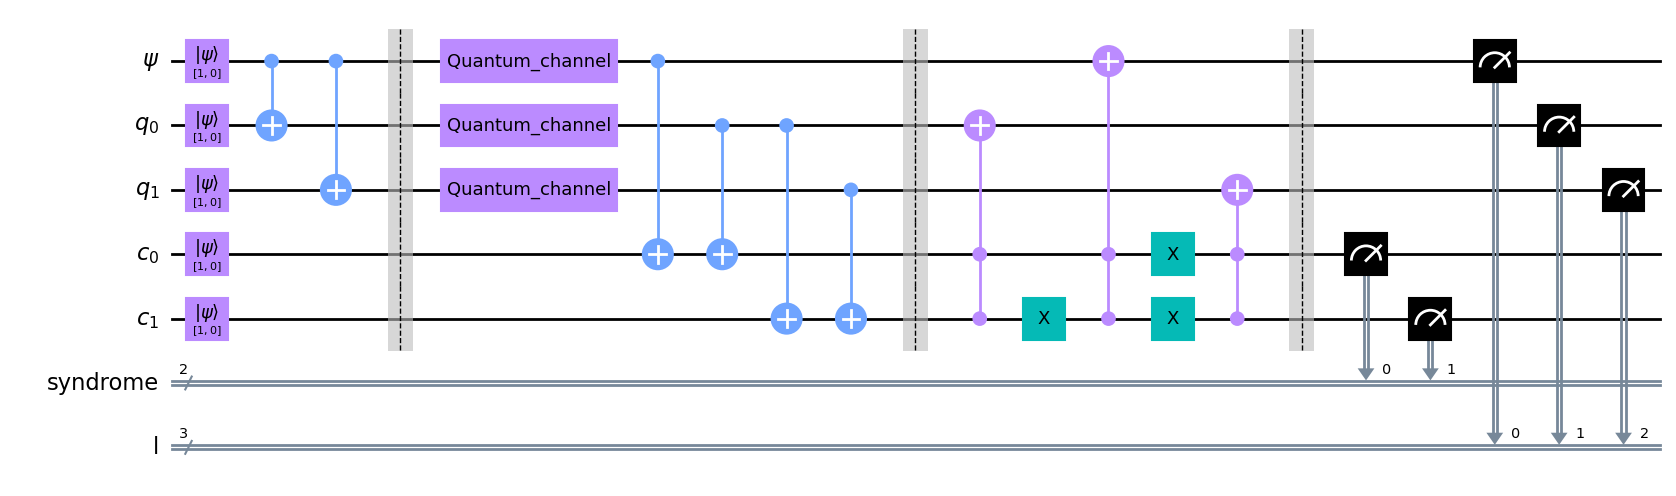

In [13]:
# add stabiliser, error correction & measure

add_stabilizer_operators     (qcircuit)
add_error_correction_circuit (qcircuit,circuit_option)
measure_logical_qubit        (qcircuit)

qcircuit.draw("mpl")

In [14]:
# Simulate
qcircuit_compiled, simulation_result = run_the_circuit(qcircuit, nm)

**Get and print/plot the measurement counts**

The measurement counts are reported as: {xxx xx}

- The first 3 counts are the measurements of {q1 q0 \psi}
  This should be either {000} or {111}, having corrected an error within the logical qubit
- The last 2 counts are the error syndrome (see Table in comments above).
  For example,
    - If no error was introduced, we should see only {00} counts
    - If a bit flip was introduced in qubit 1, should see only {01} counts


In [15]:
measurement_counts = simulation_result.get_counts(qcircuit_compiled)
print(measurement_counts)

{'111 11': 3, '111 10': 2, '111 00': 4, '000 11': 79, '000 00': 75, '000 10': 76, '000 01': 3857}


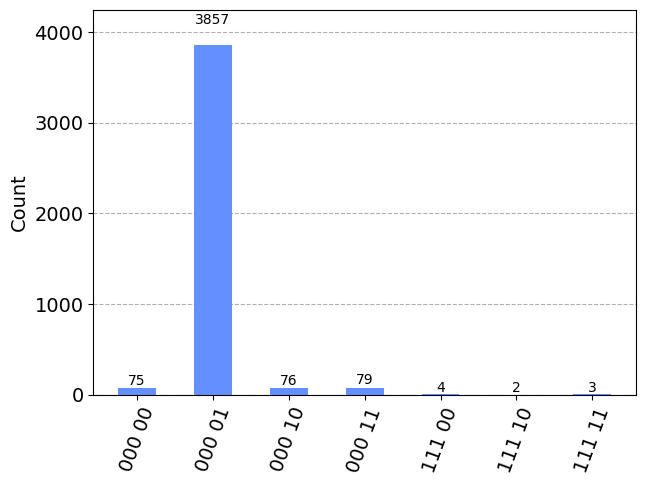

In [16]:
plot_histogram(measurement_counts)